In [91]:
import pandas as pd

In [92]:

df = pd.read_csv('sab-bma.csv')


In [93]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCACCTTCAAGAGG...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGGAAGCGCGT...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...
...,...,...
9735,AGGCTAACGCCTTTATTATATAACCACTCTTAGCCCATAGGACTAC...,AGGCTAACACACCTATTATATAACCACTCTTAGCCCATAGGACTAC...
9736,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGTATGGGCCCC...
9737,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...
9738,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...


In [94]:
from tqdm import tqdm


In [95]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [96]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [97]:
import difflib


In [98]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [99]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 9740/9740 [00:00<00:00, 99667.52it/s]


[91, 122, 177, 207, 230, 270, 318, 358, 397, 412, 476, 496, 540, 583, 630, 687, 718, 748, 794, 820, 885, 914, 973, 1009, 1031, 1080, 1114, 1139, 1239, 1278, 1294, 1386, 1437, 1462, 1524, 1544, 1634, 1680, 1706, 1721, 1809, 1852, 1893, 1932, 2020, 2044, 2038, 2107, 2210, 2212, 2258, 2279, 2307, 2357, 2454, 2709, 2667, 2576, 2522, 2498, 2452, 2375, 2347, 2252, 2200, 2145, 2095, 2080, 2010, 2021, 1952, 1914, 1869, 1778, 1727, 1740, 1669, 1614, 1554, 1513, 1445, 1406, 1378, 1299, 1281, 1181, 1158, 1078, 1060, 1007, 937, 873, 858, 764, 767, 712, 642, 590, 581, 518, 453, 424, 385, 330, 291, 248, 205, 158, 102, 86]


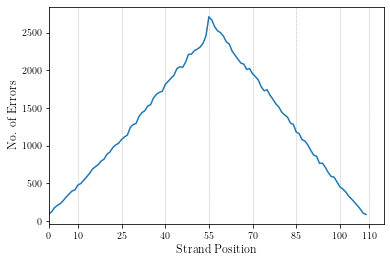

In [100]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.xlabel(r'Strand Position', fontsize=12)
plt.ylabel(r'No. of Errors', fontsize=12)
plt.grid(axis = 'x', linestyle='--', linewidth = 0.5)
plt.xlim(0, 115)
plt.xticks([0, 10, 25, 40, 55, 70, 85, 100, 110])
plt.show()
f.savefig('cov5-sab-bma-hamming.pdf', bbox_inches='tight')

In [101]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 9740/9740 [00:06<00:00, 1565.47it/s]


In [102]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


AGC ->  6
 -> TAT 6
 -> GTT 6
AAG ->  6
 -> GTG 6
C -> AGA 6
T -> CAC 6
AG -> C 6
T -> CAG 6
C -> TA 6
CCG ->  6
T -> GAC 6
CA -> G 6
GT -> CC 6
T -> GAA 6
 -> CAAA 6
G -> CAC 6
 -> TCG 7
 -> TCT 7
GCG ->  7
 -> CTG 7
ACG ->  7
ATT ->  7
ATG ->  7
 -> GAT 7
CAG ->  7
ATC ->  7
 -> GGA 7
CG -> AA 7
 -> GGC 7
 -> TAG 7
 -> CGA 7
TT -> CC 7
T -> CAA 7
TT -> CA 7
CT -> AG 7
CTA ->  7
CTC ->  7
TG -> CC 7
 -> ATG 7
TAT ->  8
TTT ->  8
TTG -> A 8
CGA ->  8
GG -> C 8
CG -> T 8
 -> GGT 8
 -> TAA 8
 -> GTC 8
AT -> G 8
GGG ->  8
 -> TGC 8
 -> TTG 8
CC -> TT 8
TAA ->  8
TC -> GA 9
GTA ->  9
ACT ->  9
 -> CCG 9
GG -> CA 9
G -> TA 9
TC -> G 9
 -> TGG 9
TT -> A 9
G -> AT 9
AGG ->  9
 -> AGT 9
 -> AGG 9
AT -> GC 9
CCC ->  9
TCG ->  9
CT -> AA 9
CGG ->  9
 -> TCC 9
 -> CTA 10
GAT ->  10
CGT ->  10
 -> GCT 10
GT -> CA 10
 -> CCT 10
 -> ATT 10
 -> TCA 10
GA -> C 10
GCA ->  10
 -> GCG 11
GC -> AA 11
TG -> AA 11
 -> TGA 11
TT -> GC 11
C -> AG 11
 -> AAT 11
TAG ->  11
 -> CTC 11
 -> AGC 11
 -> CGG 11
 -> C

A ->  @ 106 6
A ->  @ 3 6
A ->  @ 78 6
A ->  @ 62 6
A ->  @ 43 6
A ->  @ 75 6
A ->  @ 41 6
A ->  @ 44 6
 -> TC @ 57 6
A ->  @ 67 6
A ->  @ 81 6
A ->  @ 34 6
A ->  @ 69 6
A ->  @ 61 6
A ->  @ 47 6
A ->  @ 109 6
 -> TC @ 0 6
A ->  @ 24 6
A ->  @ 37 6
A ->  @ 17 6
A ->  @ 72 6
G ->  @ 28 6
GA ->  @ 55 6
G -> A @ 24 6
G -> A @ 34 6
GT ->  @ 65 6
T -> A @ 36 6
T -> A @ 46 6
T -> A @ 56 6
 -> G @ 106 6
T -> A @ 73 6
T -> A @ 77 6
T -> A @ 79 6
T -> A @ 80 6
C -> T @ 79 6
C -> T @ 76 6
C -> T @ 72 6
T ->  @ 94 6
C -> T @ 62 6
C -> T @ 51 6
C -> T @ 32 6
C -> T @ 31 6
 -> A @ 99 6
 -> A @ 98 6
C -> T @ 100 6
 -> A @ 8 6
C -> A @ 88 6
C -> A @ 86 6
A -> G @ 56 6
T -> C @ 101 6
T -> C @ 107 6
 -> A @ 70 6
T -> C @ 14 6
C -> T @ 59 6
G -> A @ 23 6
G -> A @ 20 6
T ->  @ 7 6
 -> C @ 30 6
G ->  @ 3 6
 -> C @ 35 6
 -> C @ 36 6
G ->  @ 20 6
 -> C @ 43 6
 -> C @ 61 6
 -> C @ 65 6
 -> C @ 22 6
 -> C @ 20 6
 -> C @ 15 6
 -> C @ 13 6
CT ->  @ 59 6
CT ->  @ 55 6
 -> C @ 76 6
CC ->  @ 53 6
 -> AG @ 53 6
 ->

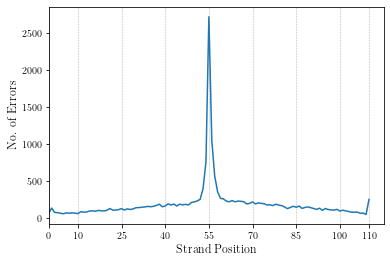

In [103]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.xlabel(r'Strand Position', fontsize=12)
plt.ylabel(r'No. of Errors', fontsize=12)
plt.grid(axis = 'x', linestyle='--', linewidth = 0.5)
plt.xlim(0, 115)
plt.xticks([0, 10, 25, 40, 55, 70, 85, 100, 110])
plt.show()
f.savefig('cov5-sab-bma-aligned.pdf', bbox_inches='tight')

In [104]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [105]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [106]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[0, 14, 12, 6, 12, 11, 13, 11, 13, 5, 12, 7, 17, 14, 20, 11, 11, 19, 14, 13, 6, 18, 17, 14, 13, 11, 12, 19, 6, 14, 19, 19, 12, 17, 17, 17, 20, 17, 23, 11, 15, 34, 18, 19, 16, 21, 23, 17, 15, 17, 13, 21, 25, 13, 21, 88, 82, 41, 21, 14, 13, 15, 14, 19, 14, 20, 21, 15, 16, 18, 16, 20, 18, 8, 11, 15, 13, 20, 20, 15, 20, 13, 10, 12, 12, 10, 17, 17, 13, 17, 19, 17, 14, 12, 12, 11, 11, 15, 16, 12, 16, 15, 13, 12, 10, 13, 13, 3, 10, 9, 117]
[0, 15, 4, 11, 8, 8, 4, 6, 5, 5, 5, 5, 6, 3, 10, 11, 10, 8, 8, 6, 13, 8, 7, 16, 11, 12, 7, 9, 7, 11, 12, 9, 12, 16, 14, 9, 16, 12, 16, 11, 19, 11, 23, 16, 17, 17, 14, 17, 12, 12, 18, 16, 15, 17, 36, 73, 85, 30, 21, 18, 13, 16, 27, 22, 19, 16, 20, 18, 21, 19, 17, 15, 11, 21, 18, 11, 20, 13, 13, 21, 12, 12, 12, 15, 9, 11, 17, 9, 15, 17, 13, 13, 8, 15, 6, 15, 10, 14, 12, 11, 12, 15, 8, 9, 9, 10, 6, 10, 11, 12, 14]
[12, 1, 5, 3, 4, 2, 1, 4, 6, 4, 2, 4, 1, 7, 4, 1, 9, 2, 3, 6, 9, 11, 7, 9, 3, 13, 3, 9, 7, 3, 12, 8, 10, 10, 4, 7, 8, 5, 10, 10, 10, 5, 13, 12, 7, 1

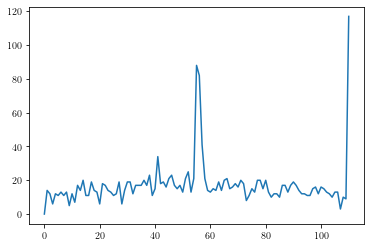

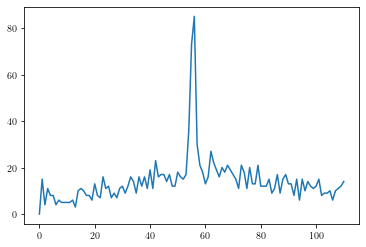

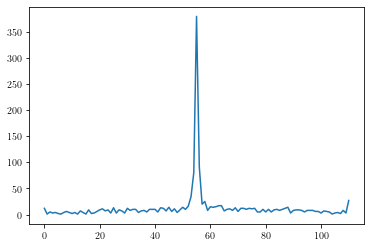

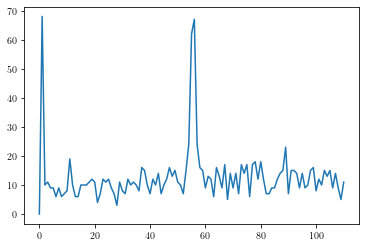

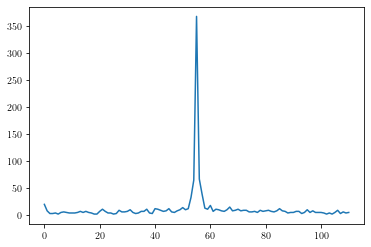

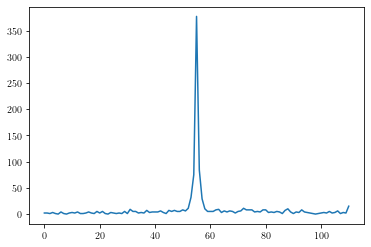

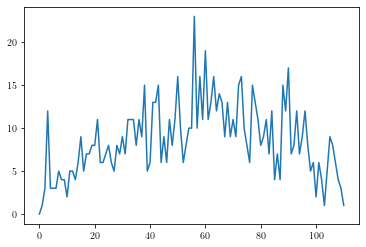

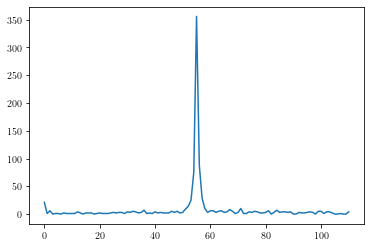

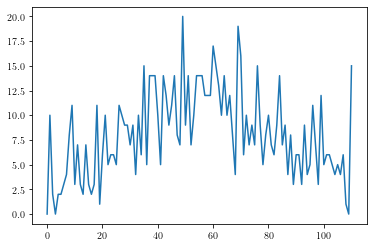

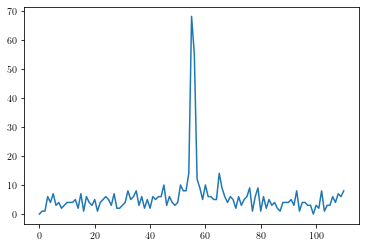

In [107]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [108]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)